# Probabilistic Mission Design - Quick Start

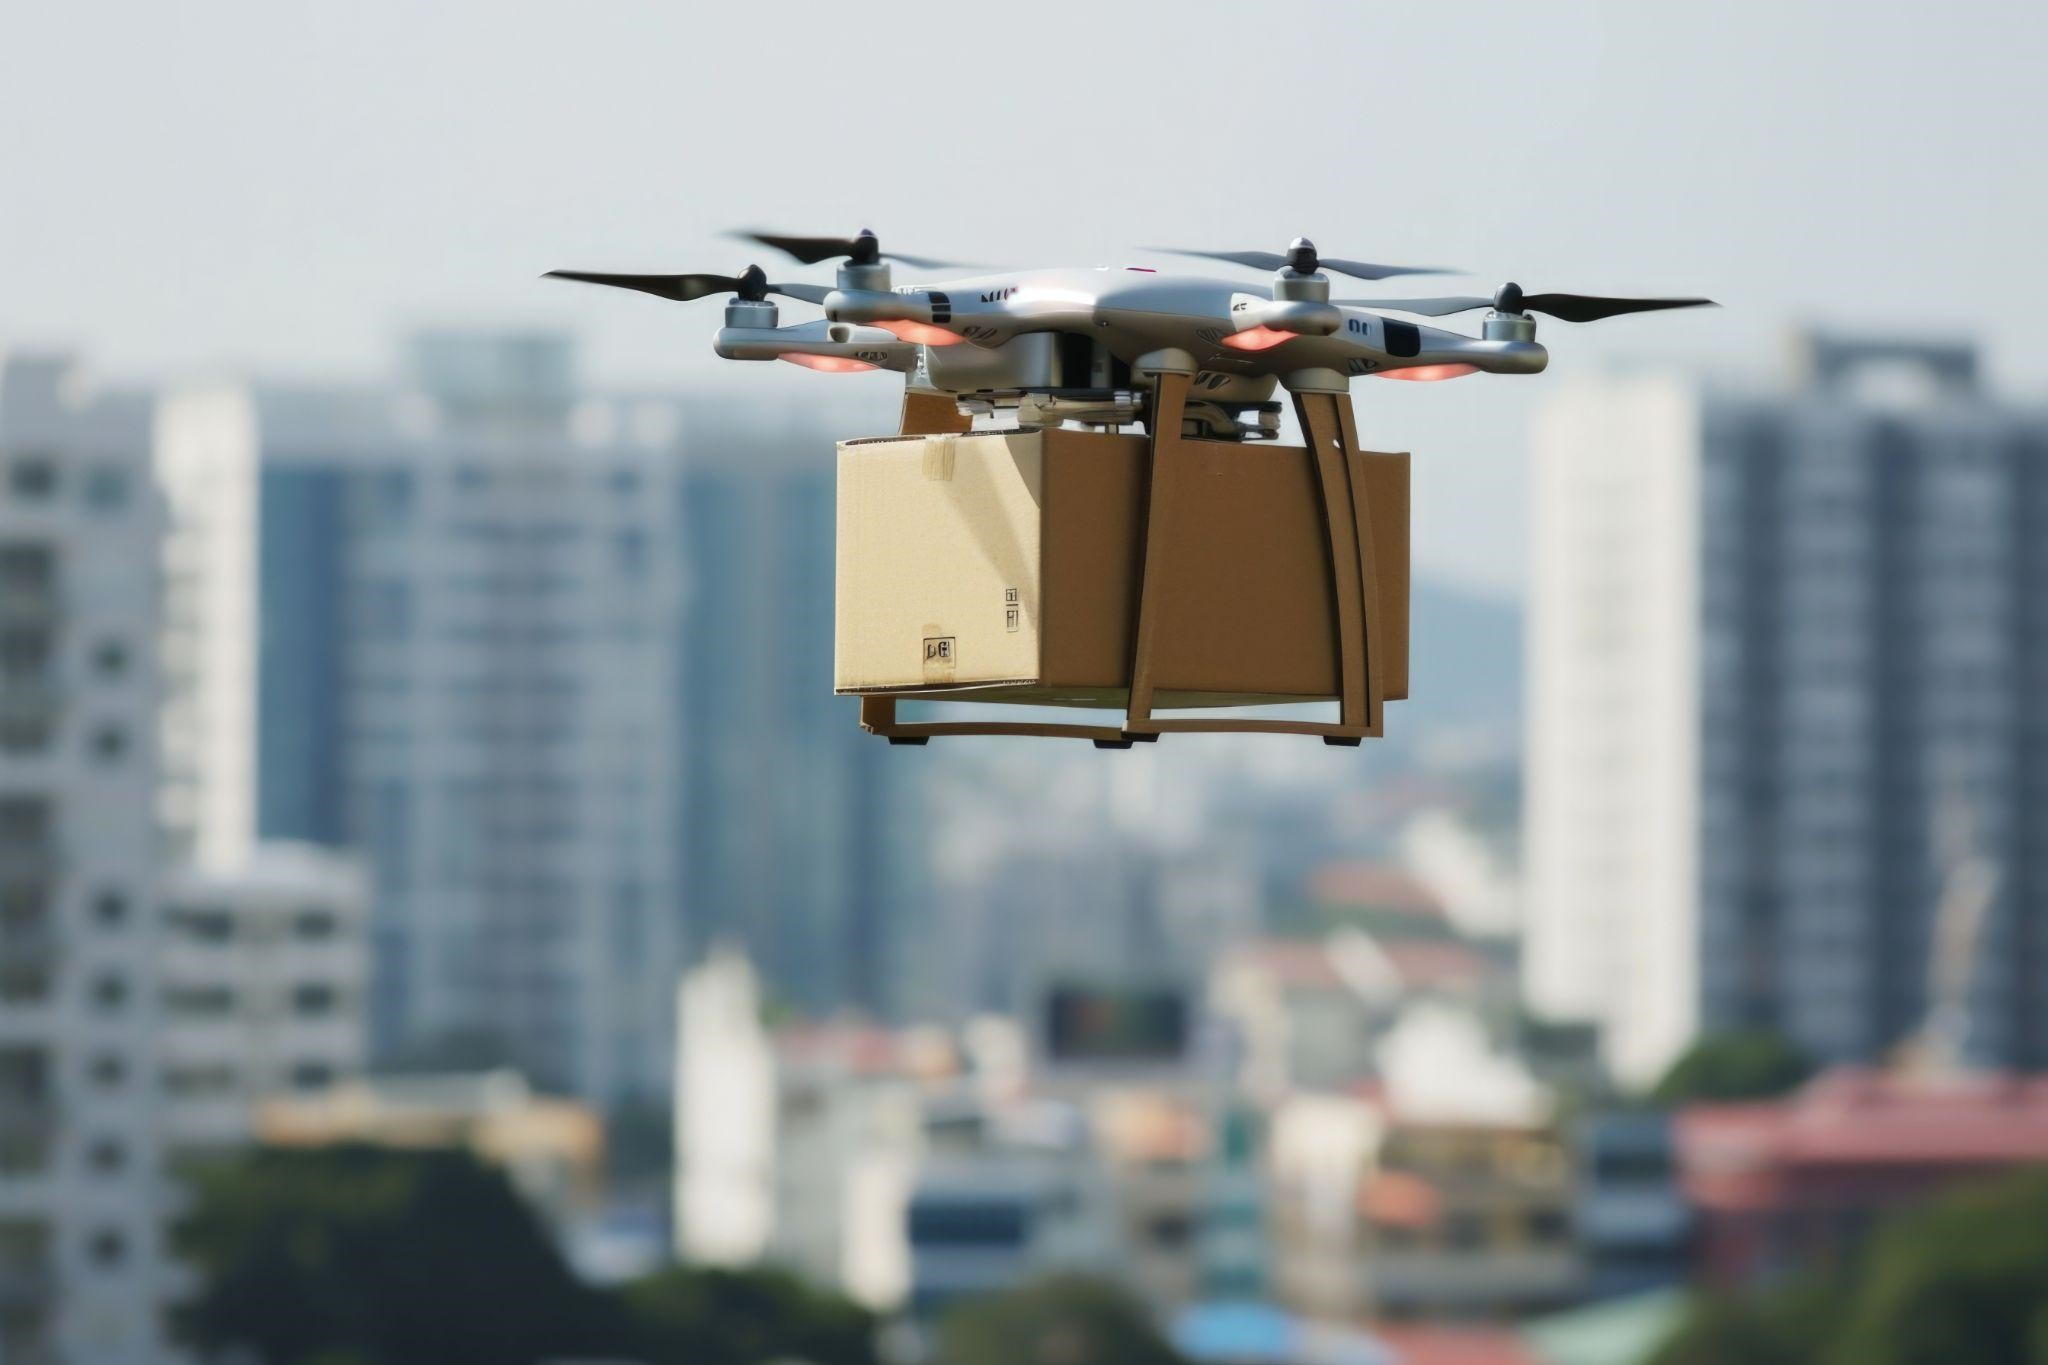

In [14]:
from numpy import eye

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )
import matplotlib.pyplot as plt


In [15]:
# The features we will load from OpenStreetMap
# The dictionary key will be stored as the respective features location_type
# The dictionary value will be used to query the relevant geometry via Overpass
feature_description = {
    "park": "['leisure' = 'park']",
    "primary": "['highway' = 'primary']",
    "primary_link": "['highway' = 'primary_link']",
    "secondary": "['highway' = 'secondary']",
    "secondary_link": "['highway' = 'secondary_link']",
    "tertiary": "['highway' = 'tertiary']",
    "service": "['highway' = 'service']",
    # "crossing": "['footway' = 'crossing']",
    # "bay": "['natural' = 'bay']",
    # "rail": "['railway' = 'rail']",

    # "fire_station": "['amenity' = 'fire_station']",
    # "police": "['amenity' = 'police']",
    # "government": "['amenity' = 'government']",
    # "hospital": "['amenity' = 'hospital']",
    # "education": "['amenity' = 'school', 'amenity' = 'kindergarten', 'amenity' = 'university']",
    "museum": "['tourism' = 'museum']",
    "library": "['amenity' = 'library']",
    "conference_centre":"['amenity' = 'conference_centre']",
    "schloss":"['historic' = 'castle']",
}

# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "primary": 15.0 * eye(2),
    "primary_link": 15.0 * eye(2),
    "secondary": 10.0 * eye(2),
    "secondary_link": 10.0 * eye(2),
    "tertiary": 5 * eye(2),
    "service": 2.5 * eye(2),
    # "fire_station": 2.5 * eye(2),
    # "police": 2.5 * eye(2),
    # "government": 2.5 * eye(2),
    # "hospital": 2.5 * eye(2),
    # "education": 2.5 * eye(2),
    "museum": 10 * eye(2),
    "library": 10 * eye(2),
    "conference_centre": 10 * eye(2),
    "schloss": 15 * eye(2),
    
    "operator": 20 * eye(2),
}
city_attr = "darmstadt"

# The mission area, points that will be estimated from 25 samples and points that will be interpolated
origin = PolarLocation(latitude=49.878091, longitude=8.654052) # Darmstadt
# origin = PolarLocation(latitude=50.110924, longitude=8.682127) # Frankfurt

# origin = PolarLocation(latitude=52.5186, longitude=13.4081) # Berlin

# origin = PolarLocation(latitude=36.8167, longitude=118.3000) # LinZi

width, height = 1000.0, 1000.0
number_of_random_maps = 20

# support = CartesianRasterBand(origin, (50, 50), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
# target = CartesianRasterBand(origin, (250, 250), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
support = CartesianRasterBand(origin, (26, 26), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(origin, (161, 161), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
# alternative = CartesianCollection(origin, [CartesianLocation(42, 42)])  # Alternatively, arbitrary points can be set for either set

In [16]:
support.data[:5]

,east,north,v0
0,-500.0,-500.0,0.0
1,-460.0,-500.0,0.0
2,-420.0,-500.0,0.0
3,-380.0,-500.0,0.0
4,-340.0,-500.0,0.0


In [17]:
target.data[:5]

,east,north,v0
0,-500.00,-500.0,0.0
1,-493.75,-500.0,0.0
2,-487.50,-500.0,0.0
3,-481.25,-500.0,0.0
4,-475.00,-500.0,0.0


In [19]:
# Setting up the Uncertainty Annotated Map from OpenStreetMap data 
load = False
if not load:
    uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
    uam.features.append(CartesianLocation(0.0, 0.0, location_type="operator"))  # We can manually add additional features
    uam.features.append(CartesianLocation(-50.0, -200.0, location_type="large_events"))  # We can manually add additional features
    uam.features.append(CartesianLocation(-200.0, 50.0, location_type="bomb"))  # We can manually add additional features
    uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
    uam.save(f"uam_{city_attr}.pkl")  # We can save and load these objects to avoid recomputation

In [ ]:
# This is formed logic:
generated_logic = """
% UAV properties
initial_charge ~ normal(90, 5).
charge_cost ~ normal(-0.1, 0.2).
weight ~ normal(0.2, 0.1).

% Real-time weather conditions for Darmstadt
weather(clear, 3.13, 17).

% Battery efficiency based on temperature
battery_efficiency(Efficiency) :-
    weather(_, _, Temp),
    (Temp < 0, Efficiency = 0.8; % Very cold
     Temp >= 0, Temp < 10, Efficiency = 0.85; % Cold
     Temp >= 10, Temp =< 35, Efficiency = 1.0; % Normal
     Temp > 35, Efficiency = 0.95 % Hot
    ).

% Visual line of sight
vlos(X) :-
    weather(Condition, _, _),
    (
        Condition = light_rain, distance(X, operator) < 20;
        Condition = cloudy, distance(X, operator) < 50;
        Condition = clear, distance(X, operator) < 100;
        Condition = clear, over(X, bay), distance(X, operator) < 400
    ).
    
weather_safe_for_flight :-
    weather(Condition, WindSpeed, _),
    safe_weather_condition(Condition),
    WindSpeed =< 15.  % Maximum safe wind speed

safe_weather_condition(clear).
safe_weather_condition(cloudy).
safe_weather_condition(light_rain).    

% Sufficient charge to return to operator
can_return(X) :-
    weather(_, WindSpeed, _),
    W is 1 + WindSpeed / 25,
    battery_efficiency(E),
    B is initial_charge, O is charge_cost,
    D is distance(X, operator), 0 < B + (2 * O * D * W / E). 

% Stay 100 meters away from bomb
sensitive_section(X) :-
    distance(X, bomb) < 50.

% Permits related to local features

permits(X) :-

    distance(X, service) < 15; 
    distance(X, primary) < 15;
    distance(X, secondary) < 10; 
    distance(X, tertiary) < 5;
    distance(X, crossing) < 5; 
    % distance(X, large_events) < 20; 
    distance(X, rail) < 5;

    over(X, education) < 15;

    over(X, park).

% Definition of a valid mission

landscape(X) :-
    weather_safe_for_flight,
    \+ sensitive_section(X),
    (
        vlos(X), weight < 25, can_return(X);
        permits(X), can_return(X)
    ).
"""
from langda import langda_solve


<pre> Langda will call the search tool to get current weather of darmstadt
 Running search tool...
[{'title': 'Darmstadt - Weather Forecast Maps - Ventusky', 'url': 'https://www.ventusky.com/darmstadt', 'content': 'Ventusky: Weather Forecast Maps\n\nDarmstadt\n\n22 °C\n\nWind28 km/h\nHumidity | 41 %\nCalculated from nearby stations (17:50 2025/05/27)\n\nWeather for the next 24 hours', 'score': 0.8674071}, {'title': 'Weather Darmstadt in May 2025: Temperature & Climate', 'url': ...

In [ ]:
city_attr = "darmstadt"
# Setting up the probabilistic spatial relations from the map data
star_map = StaRMap(target, CartesianMap.load(f"uam_{city_attr}.pkl"))
star_map.initialize(support, number_of_random_maps, generated_logic)  # This estimates all spatial relations that are relevant to the given logic
# star_map.add_support_points(support, number_of_random_maps, ["distance"], ["primary"])  # Alternatively, we can estimate for specific relations
star_map.save(f"star_map_{city_attr}.pkl")

# Solve the mission area with ProMis
promis = ProMis(StaRMap.load(f"star_map_{city_attr}.pkl"))
landscape = promis.solve(support, generated_logic, n_jobs=4, batch_size=1)
landscape.save(f"landscape.pkl")

In [ ]:
print(type(landscape.data))
landscape.data[:5]

<class 'pandas.core.frame.DataFrame'>


,east,north,v0
0,-500.00,-500.0,0.46000
1,-493.75,-500.0,0.44125
2,-487.50,-500.0,0.42250
3,-481.25,-500.0,0.40375
4,-475.00,-500.0,0.38500


## Test: Trajectories

In [ ]:
landscape = CartesianCollection.load(f"landscape.pkl")
import numpy as np
def get_confidence_at_point(east: float, north: float) -> float:

    # 找到最接近的网格点
    distances = np.sqrt((landscape.data.east - east)**2 + 
                        (landscape.data.north - north)**2)
    closest_idx = distances.idxmin()
    return landscape.data.loc[closest_idx, 'v0']

def set_path(x_pt, y_pt, path_lists):
    print(get_confidence_at_point(x_pt,y_pt))
    image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=1)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["0", "0.5", "1"]
    
    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")

    for i, path in enumerate(path_lists):
        confidence_list = []
        valid = True
        for (x,y) in path:
            confidence = np.around(get_confidence_at_point(x,y),3)
            if confidence < 0.4:
                confidence_list.append(f"Invalid")
                valid = False
            else:
                confidence_list.append(confidence)
        if valid:
            marker = "."
        else:
            marker = "x"
        plt.plot(*zip(*path), 
                marker=marker,          # 使用小点标记（也可以用 'o' 配合 markersize）
                markersize=5,        # 点的大小（原来默认约6-8）
                linewidth=1.5,       # 线条粗细
                alpha=0.8,           # 透明度
                # label=f'Path{i}'
                )
        
        print(f"Path{i}: {valid}",confidence_list)
    
    plt.legend()
    plt.title("Path Validity Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')

    # —— 在这里插入一个特殊标记 —— #
    # x_pt, y_pt = -50, 270  # 单位 m；如果想用 km，就写 0.1, 0.2
    plt.scatter(
        x_pt, y_pt,
        marker='*',       # 星形
        s=100,            # 大小
        c='red',          # 颜色
        edgecolors='black',
        linewidths=1.2,
        zorder=5          # 确保点画在最上层
    )

    plt.show()

1.0
Path0: False ['Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.584, 0.417, 'Invalid', 0.53, 'Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.933, 0.984, 0.996, 1.0, 1.0, 1.0]
Path1: False [0.503, 'Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.721, 0.965, 0.991, 1.0, 1.0]
Path2: False ['Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.574, 0.599, 0.575, 0.603, 'Invalid', 'Invalid', 0.485, 0.619, 0.667, 0.865, 0.899, 0.949, 0.971, 0.992, 1.0, 1.0, 1.0]
Path3: True [0.514, 0.506, 0.6, 0.638, 0.646, 0.65, 0.638, 0.611, 0.68, 0.804, 0.863, 0.957, 0.961, 0.977, 1.0, 1.0, 1.0, 1.0]


/var/folders/05/6btr2vg13b9gvgs3gxt8fw_40000gn/T/ipykernel_95562/141327130.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


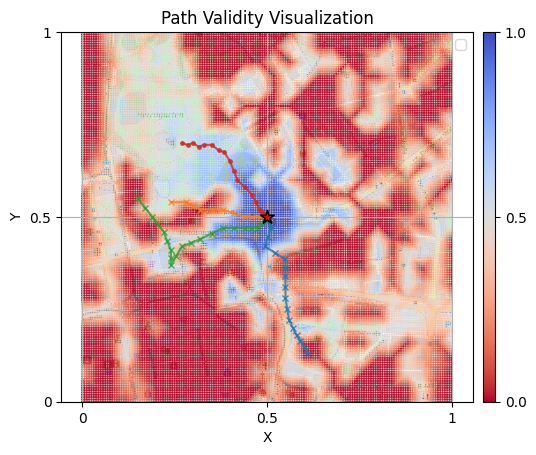

In [ ]:
# === VALID PATHS (从原始起点生成) ===
valid_paths = [
    # Path 1: 
    # [(-50,265), (-75,265), (-100,265), (-120,248), (-140,230), (-145,215), (-150,200), (-137,177), (-123,153), (-110,130), (-95,115), (-80,100), (-63,83), (-47,67), (-30,50), (-20,33), (-10,17), (0,0)],
    # Path 2:  
    [(110,-370), (105,-360), (100,-350), (90,-335), (80,-320), (70,-300), (60,-280),(55,-250), (50,-220), (50,-190), (50,-160), (50,-138), (50,-115), (23,-98),(-5,-80), (3,-55), (10,-30), (7,-20), (4,-10), (0,0)],
    # Path 3: 
    [(-260,40), (-220,40), (-200,30), (-180,20),(-150,20), (-120,20), (-90,10), (-60,0), (-40,0), (-20,0), (0,0)],
    # Path 4: 
    [(-350,50), (-330,25), (-310,0), (-295,-20), (-280,-40), (-270,-65), (-260,-90),(-260,-110), (-260,-130), (-245,-105), (-230,-80), (-205,-70), (-180,-60),(-150,-45), (-120,-30), (-90,-30), (-60,-30), (-43,-30), (-25,-30), (-13,-20),(-7,-10), (0,0)],
    [(-230, 200),
 (-215, 195),
 (-200, 200),
 (-185, 190),
 (-170, 195),
 (-150, 195),
 (-130, 180),
 (-115, 175),
 (-100, 150),
 (-90, 125),
 (-80, 100),
 (-60, 80),
 (-40, 60),
 (-30, 40),
 (-20, 20),
 (-13, 13),
 (-7, 7),
 (0, 0)],
    # Path 5: 
    # [(-230,290), (-215,275), (-200,260), (-185,240), (-170,220), (-150,210), (-130,200),(-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),(-20,20), (-13,13), (-7,7), (0,0)],
    # Path 6: 
    # [(-350,50), (-325,45), (-300,40), (-275,60), (-250,80), (-225,80), (-200,80),(-185,90), (-170,100), (-145,115), (-120,130), (-105,150), (-90,170), (-65,170),(-40,170), (-20,180), (0,190), (20,170), (40,150), (35,130), (30,110),(10,85), (-10,60), (-10,40), (-10,20), (-7,13), (-3,7), (0,0)],
    # Path 7: 
    # [ (-90,-278), (-80,-290), (-60,-290), (-20,-290), (-20,-270), (-20,-250),(-10,-235), (0,-220), (15,-220), (30,-210), (38,-195), (45,-180), (43,-160),(40,-140), (30,-120), (20,-100), (10,-90), (0,-80), (-10,-60), (-20,-40),(-13,-27), (-7,-13), (0,0)],
    # Path 8: 
    # [(200,40), (190,20), (180,0), (160,-10), (140,-20), (120,-25), (100,-30), (80,-25), (60,-20), (45,-15), (30,-10), (15,-5), (0,0)],
    # Path 9: 
    # [(135,210), (135,195), (135,180), (123,160), (110,140), (90,145), (70,150), (50,140), (30,130), (15,115), (0,100), (-8,80), (-15,60), (-23,45), (-30,30), (-20,20), (-10,10), (0,0)],
    # Valid10: 
    # [(-50, 265), (-70, 240), (-90, 210), (-110, 180), (-130, 150), (-150, 120), (-120, 90), (-90, 60), (-60, 30), (-30, 15), (0, 0)],
    # Valid11:  
    # [(110, -370), (90, -350), (70, -330), (50, -300), (30, -270), (10, -240), (-10, -210), (-30, -180), (-50, -150), (-40, -120), (-30, -90), (-20, -60), (-10, -30), (0, 0)],   
    # Valid16: 
    # [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)],
    # Valid17: 
    # [(200, 40), (180, 30), (160, 20), (140, 10), (120, 0), (100, -10), (80, -5), (60, 0), (40, 5), (20, 10), (10, 5), (0, 0)],
    # Valid18: 
    # [(135, 210), (120, 190), (105, 170), (90, 150), (75, 130), (60, 110), (45, 90), (30, 70), (15, 50), (10, 30), (5, 15), (0, 0)],
    # Invalid13: 
    # [(-50, 265), (-30, 240), (-10, 215), (10, 190), (30, 165), (50, 140), (40, 115), (30, 90), (20, 65), (10, 40), (5, 20), (0, 0)],
    # Invalid14: 
    # [(110, -370), (100, -340), (90, -310), (80, -280), (70, -250), (60, -220), (80, -190), (100, -160), (90, -130), (80, -100), (70, -70), (60, -40), (30, -20), (0, 0)],
    # Invalid15: 
    # [(-350, 50), (-320, 70), (-290, 90), (-260, 110), (-230, 130), (-200, 150), (-170, 130), (-140, 110), (-110, 90), (-80, 70), (-50, 50), (-25, 30), (0, 0)],
    # Invalid17: 
    # [(-230, 290), (-200, 280), (-170, 270), (-140, 260), (-110, 250), (-80, 240), (-50, 220), (-20, 200), (10, 180), (40, 160), (50, 130), (40, 100), (30, 70), (20, 40), (10, 20), (0, 0)],
    # Invalid19: 
    # [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (40, -90), (60, -65), (80, -40), (70, -20), (50, -10), (25, -5), (0, 0)],
    # Invalid20: 
    # [(200, 40), (180, 60), (160, 80), (140, 100), (120, 120), (100, 140), (80, 120), (60, 100), (40, 80), (20, 60), (10, 40), (5, 20), (0, 0)],
    # Invalid21: 
    # [(135, 210), (110, 200), (85, 190), (60, 180), (35, 170), (10, 160), (-15, 150), (-40, 140), (-20, 120), (0, 100), (20, 80), (40, 60), (30, 40), (20, 20), (10, 10), (0, 0)]
]
set_path(-0,-0, valid_paths) 

1.0
Path0: False [0.521, 0.433, 'Invalid', 0.703, 0.719, 0.722, 0.759, 0.906, 0.978, 0.994, 1.0]
Path1: False [0.556, 0.484, 'Invalid', 'Invalid', 0.541, 0.663, 0.659, 0.593, 0.685, 0.851, 0.966, 0.978, 0.994, 1.0]
Path2: True [0.799, 0.739, 0.673, 0.609, 0.684, 0.819, 0.897, 0.95, 0.969, 0.991, 1.0, 1.0]
Path3: False ['Invalid', 'Invalid', 'Invalid', 0.711, 0.853, 0.9, 0.937, 0.966, 0.989, 1.0, 1.0, 1.0]
Path4: False ['Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.481, 0.81, 0.985, 0.994, 1.0, 1.0]
Path5: False [0.521, 0.429, 'Invalid', 0.611, 0.439, 'Invalid', 'Invalid', 0.566, 0.948, 0.991, 1.0, 1.0]
Path6: False [0.556, 0.505, 'Invalid', 'Invalid', 0.581, 0.684, 0.62, 0.714, 0.792, 0.599, 0.833, 0.9, 0.994, 1.0]
Path7: False ['Invalid', 'Invalid', 'Invalid', 'Invalid', 0.499, 0.62, 0.684, 0.744, 0.75, 0.897, 0.995, 0.998, 1.0]
Path8: False ['Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 'Invalid', 0.42, 'Invalid', 0.63, 0.439, 'Invalid', 'Invalid', 0.81

/var/folders/05/6btr2vg13b9gvgs3gxt8fw_40000gn/T/ipykernel_48780/141327130.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


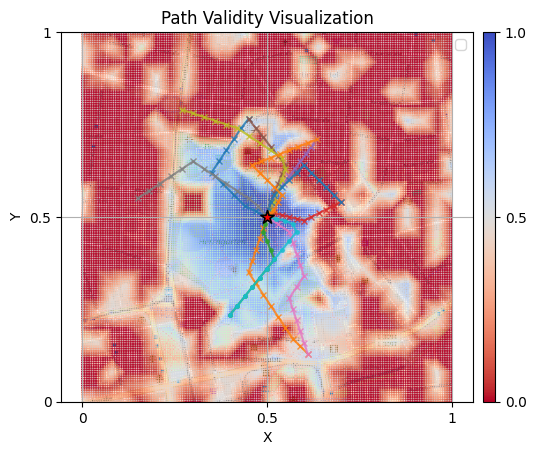

In [ ]:
# === INVALID PATHS (从原始起点生成) ===
invalid_paths = [
    # Valid10: 从起点(-50, 265)生成
    [(-50, 265), (-70, 240), (-90, 210), (-110, 180), (-130, 150), (-150, 120), (-120, 90), (-90, 60), (-60, 30), (-30, 15), (0, 0)],
    # Valid11: 从起点(110, -370)生成  
    [(110, -370), (90, -350), (70, -330), (50, -300), (30, -270), (10, -240), (-10, -210), (-30, -180), (-50, -150), (-40, -120), (-30, -90), (-20, -60), (-10, -30), (0, 0)],   
    # Valid16: 从起点(-100, -265)生成
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)],
    # Valid17: 从起点(200, 40)生成
    [(200, 40), (180, 30), (160, 20), (140, 10), (120, 0), (100, -10), (80, -5), (60, 0), (40, 5), (20, 10), (10, 5), (0, 0)],
    # Valid18: 从起点(135, 210)生成
    [(135, 210), (120, 190), (105, 170), (90, 150), (75, 130), (60, 110), (45, 90), (30, 70), (15, 50), (10, 30), (5, 15), (0, 0)],
    # Invalid13: 从起点(-50, 265)生成 - 直线穿越中央红色区域
    [(-50, 265), (-30, 240), (-10, 215), (10, 190), (30, 165), (50, 140), (40, 115), (30, 90), (20, 65), (10, 40), (5, 20), (0, 0)],
    # Invalid14: 从起点(110, -370)生成 - 穿越右侧红色区域后直行
    [(110, -370), (100, -340), (90, -310), (80, -280), (70, -250), (60, -220), (80, -190), (100, -160), (90, -130), (80, -100), (70, -70), (60, -40), (30, -20), (0, 0)],
    # Invalid15: 从起点(-350, 50)生成 - 向上穿越左上红色区域
    [(-350, 50), (-320, 70), (-290, 90), (-260, 110), (-230, 130), (-200, 150), (-170, 130), (-140, 110), (-110, 90), (-80, 70), (-50, 50), (-25, 30), (0, 0)],
    # Invalid17: 从起点(-230, 290)生成 - 向右上穿越红色区域
    [(-230, 290), (-200, 280), (-170, 270), (-140, 260), (-110, 250), (-80, 240), (-50, 220), (-20, 200), (10, 180), (40, 160), (50, 130), (40, 100), (30, 70), (20, 40), (10, 20), (0, 0)],
    # Invalid19: 从起点(-100, -265)生成 - 向东北穿越红色区域
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (40, -90), (60, -65), (80, -40), (70, -20), (50, -10), (25, -5), (0, 0)],
    # Invalid20: 从起点(200, 40)生成 - 向北穿越右上红色区域
    [(200, 40), (180, 60), (160, 80), (140, 100), (120, 120), (100, 140), (80, 120), (60, 100), (40, 80), (20, 60), (10, 40), (5, 20), (0, 0)],
    # Invalid21: 从起点(135, 210)生成 - 向西北穿越红色区域
    [(135, 210), (110, 200), (85, 190), (60, 180), (35, 170), (10, 160), (-15, 150), (-40, 140), (-20, 120), (0, 100), (20, 80), (40, 60), (30, 40), (20, 20), (10, 10), (0, 0)]
]

set_path(-0,-0, invalid_paths) 

In [ ]:
import re
import ast
from pathlib import Path 
from problog import get_evaluatable
from langda import langda_solve
danger_rules_string = f"""
langda(LLM:"According to the user: /* Ask */, 
please extract the points and form as: fly([]).
store all the points inside the list").

query(fly(X)).
"""

special_model = langda_solve("single_dc", danger_rules_string, "deepseek-chat", 
            prefix="telegram_bot_fly", langda_ext={"Ask":"I just updated my flying plan: [(-230,200), (-215,195), (-200,200), (-185,190), (-170,195), (-150,195), (-130,180),(-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),(-20,20), (-13,13), (-7,7), (0,0)], please check if it's valid or not"},
            load=False)
special_result = get_evaluatable().create_from(special_model).evaluate()

key = next(iter(special_result))  # 提取唯一键

# 用正则找出中括号部分
match = re.search(r"fly\((\[.*\])\)", str(key))
if match:
    list_str = match.group(1)       # 获取 "[(-230, 200), ..., (0, 0)]"
    coord_list = ast.literal_eval(list_str)  # 安全地解析为 Python 列表
    print(f"Parsed coordinates: {coord_list}")
    



### =========== processing init_node =========== ###
[{'LOT': None, 'NET': None, 'LLM': 'According to the user: /* Ask */, \nplease extract the points and form as: fly([]).\nstore all the points inside the list', 'FUP': 'True', 'HEAD': '', 'HASH': '6D097EB4'}]
{'6D097EB4': 'fly([(-230,200), (-215,195), (-200,200), (-185,190), (-170,195), (-150,195), (-130,180), (-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40), (-20,20), (-13,13), (-7,7), (0,0)]).'}
prompt from external received: I just updated my flying plan: [(-230,200), (-215,195), (-200,200), (-185,190), (-170,195), (-150,195), (-130,180),(-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),(-20,20), (-13,13), (-7,7), (0,0)], please check if it's valid or not
[{'6D097EB4': None}]
processing _decide_next_init ...
### =========== ### current round: 0 ### =========== ###
### =========== processing generate_node =========== ###
Executing first chain: Code generation with tools...


> Enter

In [ ]:
coord_list

[(-230, 200),
 (-215, 195),
 (-200, 200),
 (-185, 190),
 (-170, 195),
 (-150, 195),
 (-130, 180),
 (-115, 175),
 (-100, 150),
 (-90, 125),
 (-80, 100),
 (-60, 80),
 (-40, 60),
 (-30, 40),
 (-20, 20),
 (-13, 13),
 (-7, 7),
 (0, 0)]

In [ ]:

def set_path(x_pt, y_pt, path, save_dir):
    """
    args:
        x_pt, y_pt: will be marked as special mark on the map
        save_dir: save directory
    """
    print("Rendering mission landscape...")
    landscape = CartesianCollection.load(f"{save_dir}/landscape.pkl")

    print(get_confidence_at_point(landscape, x_pt, y_pt))
    image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=1)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["0", "0.5", "1"]
    
    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")
    confidence_list = []
    # for i, path in enumerate(path_lists):
    #     confidence_list = []
    valid = True
    for (x,y) in path:
        confidence = np.around(get_confidence_at_point(landscape, x, y),3)
        if confidence < 0.4:
            confidence_list.append(f"Invalid")
            valid = False
        else:
            confidence_list.append(confidence)
    if valid:
        marker = "."
    else:
        marker = "x"
    plt.plot(*zip(*path), 
            marker=marker,
            markersize=5,
            linewidth=1.5,
            alpha=0.8,
            # label=f'Path{i}'
            )
    
    print(f"Path: {valid}",confidence_list)
    
    plt.legend()
    plt.title("Path Validity Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')

    # —— Special mark at x_pt, y_pt —— #
    plt.scatter(
        x_pt, y_pt,
        marker='*',
        s=100,
        c='red',
        edgecolors='black',
        linewidths=1.2,
        zorder=5          # 确保点画在最上层
    )

    plt.savefig(
        f"{save_dir}/mission_landscape.png", 
        dpi=100,
        format='png',
        bbox_inches='tight',
        transparent=False)
    plt.close()
    print(f"Landscape plot saved to mission_landscape.png")
    return confidence_list

In [ ]:
set_path(0,0,coord_list,"")

Rendering mission landscape...


FileNotFoundError: [Errno 2] No such file or directory: '/landscape.pkl'